# *Importing Required tools*



In [26]:
!pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
#Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
from torch.nn.modules.activation import ReLU
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from sklearn import metrics

# *Splitting the train data to create validataion data*

In [ ]:
input_folder = '/content/drive/MyDrive/assignment1_data/classification_dataset/train'
output_folder = '/content/drive/MyDrive/assignment1_data/' +'split'
splitfolders.ratio(input_folder, output = output_folder, seed = 1337, ratio = (0.8, 0.2), group_prefix=None, move = False )

# *Data transforms defined on train, val and test dataset*

In [28]:
# Transforms used to normalise the datasets
# After calculting the mean and standard deviation of the data set,
# I observed that it has approximately the same values as the ImageNet dataset

data_transforms ={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.47949,0.4665, 0.4086], [0.2849, 0.2770, 0.2849])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.47949,0.4665, 0.4086], [0.2849, 0.2770, 0.2849])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.47949,0.4665, 0.4086], [0.2849, 0.2770, 0.2849])         
    ])
}

# *Loading train, val and test data to a dictionary*

In [29]:
test_dir = '/content/drive/MyDrive/assignment1_data/classification_dataset'

#Initially taking the train and val data into the dictionary after applying transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val']}

#Adding test data to the dictionary after applying transforms
image_datasets['test'] = datasets.ImageFolder(os.path.join(test_dir, 'test'), data_transforms['test'])

#batch_size defined as per the usage in next cells
batch_size = {'train': 4, 'val': 4, 'test': 120}

#Train and Val data is shuffled and test data is not
shuffle = {'train': 'True', 'val': 'True', 'test': 'False'}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size[x], shuffle = shuffle[x], num_workers = 2) for x in ['train', 'val','test']}
dataset_sizes = {x :len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print('Train, Val and Test dataset after splitting and saving in the dictionary\n')
print(dataset_sizes,'\n')
print('Class Names are as follows:\n')
print(class_names)

Train, Val and Test dataset after splitting and saving in the dictionary

{'train': 423, 'val': 109, 'test': 120} 

Class Names are as follows:

['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']


# *Device Information*

In [30]:
torch.cuda.is_available()

True

In [31]:
torch.cuda.device_count()

1

In [32]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# *Building our simple neural network with 3 convolution layers*

In [34]:
class ConvNeuralNet(nn.Module):
	#  Determine the layers and their order in CNN object 
  # 3 convolution layers and one Fully connected layer
    def __init__(self, num_classes = 10):
        super(ConvNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size= 5, stride = 1, padding = 2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size= 5, stride = 1, padding = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)  
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size= 5, stride = 1, padding = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size = (1,1))
        )
        
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
   

# *Using SGD Optimizer*

In [35]:
model = ConvNeuralNet(num_classes).to(device)

#Using crossentropy loss and stochastic gradient descent

criterion = torch.nn.CrossEntropyLoss()
optimizer_fc = torch.optim.SGD(model.fc.parameters(), lr = 0.01, momentum = 0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fc, step_size = 7, gamma = 0.1)

# *Training our Model*

In [36]:
#Train model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_acc = []
    val_acc = []
    test_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                if phase != 'test':
                  running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            # Storing each epoch accuracies for train, test and val data

            if phase != 'test':
              epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              train_acc.append(epoch_acc )
            elif phase == 'val':
              val_acc.append(epoch_acc)
            else:
              test_acc.append(epoch_acc)
            if phase != 'test':
              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            else:
              print(f'Test accuracy for current epoch: {epoch_acc:.4f}')
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, val_acc, test_acc

In [37]:

#Training the model(only last layer) using SGD optimizer

model, train_acc, val_acc, test_acc = train_model(model, criterion, optimizer_fc, exp_lr_scheduler, num_epochs = 25)

#Storing each epoch accuracies for train, val and test

train_acc = torch.tensor(train_acc, device = 'cpu').numpy()
val_acc = torch.tensor(val_acc, device = 'cpu').numpy()
test_acc = torch.tensor(test_acc, device = 'cpu').numpy()

Epoch 0/24
----------
train Loss: 1.8555 Acc: 0.1489
val Loss: 1.7778 Acc: 0.2661
Test accuracy for current epoch: 0.2333

Epoch 1/24
----------
train Loss: 1.7799 Acc: 0.2435
val Loss: 1.6844 Acc: 0.2477
Test accuracy for current epoch: 0.2000

Epoch 2/24
----------
train Loss: 1.7550 Acc: 0.2600
val Loss: 1.6279 Acc: 0.3211
Test accuracy for current epoch: 0.3750

Epoch 3/24
----------
train Loss: 1.7530 Acc: 0.2671
val Loss: 1.6435 Acc: 0.3119
Test accuracy for current epoch: 0.2417

Epoch 4/24
----------
train Loss: 1.7168 Acc: 0.2837
val Loss: 1.6674 Acc: 0.3303
Test accuracy for current epoch: 0.4000

Epoch 5/24
----------
train Loss: 1.7376 Acc: 0.2600
val Loss: 1.6820 Acc: 0.3486
Test accuracy for current epoch: 0.3917

Epoch 6/24
----------
train Loss: 1.7247 Acc: 0.2695
val Loss: 1.7298 Acc: 0.2569
Test accuracy for current epoch: 0.3250

Epoch 7/24
----------
train Loss: 1.7015 Acc: 0.3026
val Loss: 1.6321 Acc: 0.3394
Test accuracy for current epoch: 0.3833

Epoch 8/24
-----

# *Plotting the accuracies during training*

Text(0, 0.5, 'Accuracy')

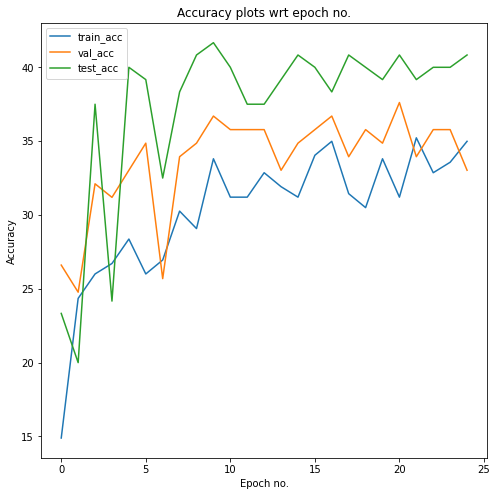

In [47]:
# Plotting accuracies

fig = plt.figure(figsize=(8, 8))
plt.plot(train_acc * 100)
plt.plot(val_acc * 100)
plt.plot(test_acc * 100)
plt.legend(['train_acc', 'val_acc', 'test_acc'])
plt.title('Accuracy plots wrt epoch no.')
plt.xlabel('Epoch no.')
plt.ylabel('Accuracy')

# *Evalutaion*

In [46]:
#Model in Evaluation mode

model.eval()
with torch.no_grad():
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
  
  predections = model(inputs)
  _, preds = torch.max(predections, 1)
  predictions = preds.cpu().numpy()
  label_list = labels.numpy()
  count = 0

# Accuracy calculation
  true_label = []
  pred_label = []
  
  for i in range(len(predictions)):
    true_label.append(class_names[label_list[i]])
    pred_label.append(class_names[predictions[i]])
    if predictions[i] == label_list[i]:
      count += 1
  print("Accuracy on Test data is: ", count * 100.0/len(label_list))
  print('\n\n                ###### CLASSIFICATION REPORT ###### \n\n')
  print(metrics.classification_report(true_label, pred_label))
  print("\n\n CONFUSION MATRIX\n\n")
  print(metrics.confusion_matrix(true_label, pred_label))

Accuracy on Test data is:  40.833333333333336


                ###### CLASSIFICATION REPORT ###### 


              precision    recall  f1-score   support

        bear       0.67      0.10      0.17        20
   butterfly       0.41      0.55      0.47        20
       camel       0.46      0.65      0.54        20
       chimp       0.43      0.65      0.52        20
        duck       0.38      0.15      0.21        20
    elephant       0.29      0.35      0.32        20

    accuracy                           0.41       120
   macro avg       0.44      0.41      0.37       120
weighted avg       0.44      0.41      0.37       120



 CONFUSION MATRIX


[[ 2  4  5  5  1  3]
 [ 0 11  3  1  3  2]
 [ 0  3 13  2  0  2]
 [ 0  4  0 13  0  3]
 [ 1  3  3  3  3  7]
 [ 0  2  4  6  1  7]]


# *Visualiizing the model - Printing a few images with their predicted labels*

In [40]:
#Visualize the model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')

                #Inverting the previously applied transform so that we can view the image normally
                
                invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

                inv_tensor = invTrans(inputs.cpu().data[j])
                plt.imshow(inv_tensor.permute(1,2,0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

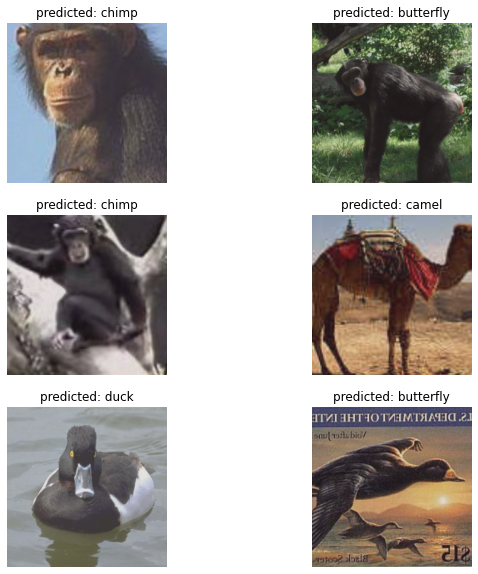

In [43]:
#Visualizing our model and printing few images with their labels

visualize_model(model)